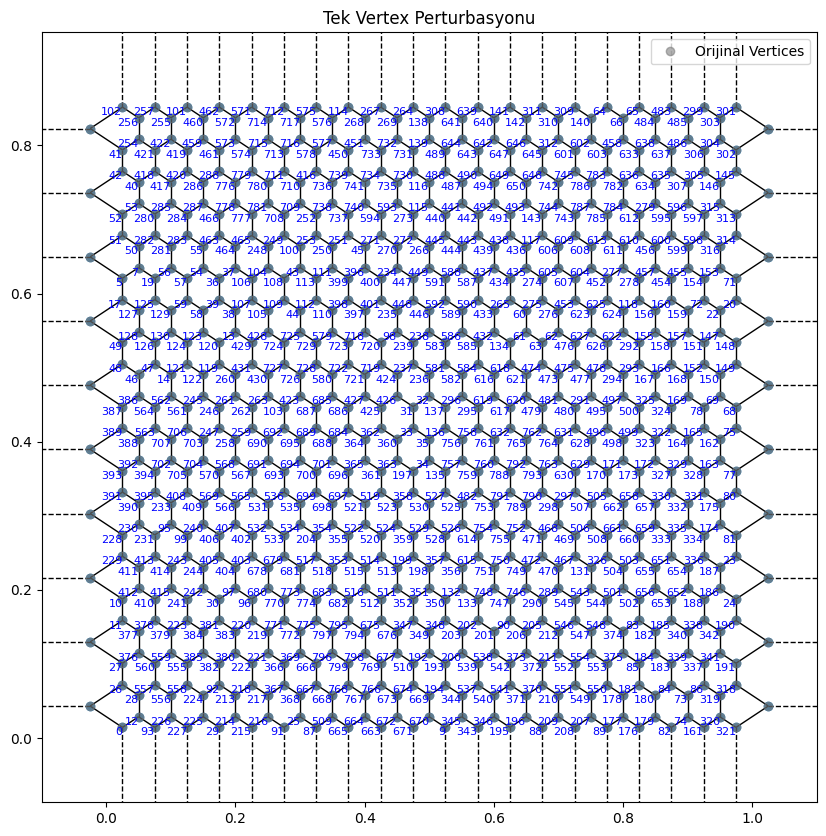

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats.qmc import LatinHypercube
from scipy.stats.qmc import Halton


def hex_points(nx=20, ny=20, jitter=0.0, seed=42):
    """
    Generate points on a hexagonal lattice inside [0,1]x[0,1], then add small jitter.
    nx, ny: number of lattice steps in x and y directions
    jitter: fraction of lattice spacing for random displacement (0 = perfect lattice)
    """
    rng = np.random.default_rng(seed)
    a = 1.0 / nx                          # lattice spacing in x
    # vertical spacing
    dy = np.sqrt(3)/2 * a                 
    # Estimate rows to fill [0,1] in y:
    ny = int(np.ceil(1.0/dy)) if ny is None else ny

    pts = []
    for j in range(ny+1):
        y = j*dy
        if y > 1.0: break
        # offset every other row
        x_offset = 0.5*a if (j % 2) else 0.0
        i_max = int(np.ceil((1.0 - x_offset)/a))
        for i in range(i_max+1):
            x = x_offset + i*a
            if 0.0 <= x <= 1.0:
                pts.append([x, y])

    pts = np.array(pts, dtype=float)

    # Add small random jitter (kept inside the unit square by clipping)
    jitter_scale_x = jitter * a
    jitter_scale_y = jitter * dy
    pts += rng.normal(0.0, 1.0, pts.shape) * [jitter_scale_x, jitter_scale_y]
    pts = np.clip(pts, 0.0, 1.0)
    return pts

def hexagonal_lattice(nx, ny, spacing):
    """
    Generate a hexagonal lattice of points.

    Parameters
    ----------
    nx : int
        Number of cells in the x direction.
    ny : int
        Number of cells in the y direction.
    spacing : float
        Distance between neighboring points.

    Returns
    -------
    Lx : float
        Total lattice length in x direction.
    Ly : float
        Total lattice length in y direction.
    points : ndarray of shape (N, 2)
        Array of (x, y) coordinates of lattice points.
    """
    # Horizontal and vertical spacings for hexagonal tiling
    dx = spacing
    dy = np.sqrt(3) / 2 * spacing

    points = []
    for j in range(ny):
        for i in range(nx):
            x = i * dx + (0.5 * dx if j % 2 else 0.0)  # offset every other row
            y = j * dy
            points.append((x, y))
    
    points = np.array(points)
    
    # Domain dimensions
    Lx = (nx - 1) * dx + 0.5 * dx  # include offset width
    Ly = (ny - 1) * dy

    return Lx, Ly, points
# ---------------------------------------------------------------
# 1. Voronoi diyagramı oluştur
# ---------------------------------------------------------------
# np.random.seed(5)
# 0- 40 arası rastgele 2D nokta
# points = np.random.rand(500, 2)
# points = Halton(d=2, scramble=True).random(500)
# points = LatinHypercube(d=2).random(n=500)  # Latin Hypercube Sampling
# points = np.random.rand(1000, 2) 
points = hex_points(nx=20, ny=20, jitter=0.00, seed=42)
# Lx, Ly, points = hexagonal_lattice(nx=20, ny=20, spacing=0.5)




buffer = 0.1

xmin, ymin = np.min(points, axis=0) - buffer
xmax, ymax = np.max(points, axis=0) + buffer

ghost_x = np.linspace(xmin, xmax, 10)
ghost_y = np.linspace(ymin, ymax, 10)
ghosts = np.array([
    [x, y]
    for x in ghost_x for y in ghost_y
    if (x < np.min(points[:, 0]) or x > np.max(points[:, 0]) or
        y < np.min(points[:, 1]) or y > np.max(points[:, 1]))
])

all_points = np.vstack([points, ghosts])
N_real = len(points)

all_points = points

vor = Voronoi(all_points,qhull_options='Qbb Qx Qc A0.9999999')  # Qbb: bounding box, Qc: convex hull, Qx: exact arithmetic, Qz: add points at infinity
# vor = Voronoi(all_points,qhull_options='Qc')  # Qbb: bounding box, Qc: convex hull, Qx: exact arithmetic, Qz: add points at infinity



# ---------------------------------------------------------------
# 3. Çizim
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 10))

# Voronoi kenarları
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=True,)

# Orijinal vertex’ler (gri)
ax.plot(vor.vertices[:, 0], vor.vertices[:, 1], 'o', color='gray', label='Orijinal Vertices', alpha=0.6)



# plot the index of points whose coordinates are between 0 and 40
for i, (x, y) in enumerate(vor.vertices):
    if 0 < x < 1 and 0 < y < 1:
        ax.text(x, y, str(i), color='blue', fontsize=8, ha='right', va='top')

ax.legend()
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_aspect('equal')
ax.set_title("Tek Vertex Perturbasyonu")

# plot the index of points



# save the figure
plt.savefig('single_vertex_perturbation.png', dpi=600, bbox_inches=None)

# plt.tight_layout()
plt.show()


In [44]:
# perturb vertices:
perturbation_strength = 0.01  # Adjust this value to control the amount of perturbation
vertices_coords = vor.vertices.copy()
maxx_vertices = np.max(vertices_coords[:,0])
minx_vertices = np.min(vertices_coords[:,0])
maxy_vertices = np.max(vertices_coords[:,1])
miny_vertices = np.min(vertices_coords[:,1])
Lx = maxx_vertices - minx_vertices
Ly = maxy_vertices - miny_vertices


# finite_mask = np.all(np.isfinite(vertices_coords), axis=1)


# for idx in np.where(finite_mask)[0]:
#     px, py = vertices_coords[idx]
#     vertices_coords[idx, :] += perturbation_strength * np.array([px/maxx_vertices,0])



# # Random perturbation of Voronoi vertices
# for idx, (px, py) in enumerate(vertices_coords):
#     # mag = 0.2*np.random.rand()*np.sin(px/Lx*np.pi)*np.sin(py/Ly*np.pi)
#     mag = 0.01*np.sin(px/Lx*np.pi)*np.sin(py/Ly*np.pi)
#     direction = np.random.uniform(0, 2*np.pi)
#     vertices_coords[idx, :] += mag * np.array([np.cos(direction), np.sin(direction)])


center_of_box = np.array([Lx/2, Ly/2], float)
center_idx = np.argmin(np.linalg.norm(vertices_coords - center_of_box[None, :], axis=1))
center_pt  = vertices_coords[center_idx].copy()   # keep for distance calculations later
px0 = center_pt[0]
py0 = center_pt[1]

sigma = 1
# Perturb gradually from left to right
for idx, (px, py) in enumerate(vertices_coords):
    # mag = 0.001*np.exp(-((px-Lx/2)**2+(py-Ly/2)**2)/(sigma**2))
    mag = 0.01*np.exp(-((px-px0)**2+(py-py0)**2)/(sigma**2))
    # direction = rng.uniform(0, 2*np.pi)
    # vertices_coords[idx, :] += mag * np.array([np.cos(direction), np.sin(direction)])
    # vertices_coords[idx, :] += mag * np.array([0, 1])
    # vertices_coords[idx, :] += mag * np.array([1, 0])
    
    v = np.array([px - px0, py - py0])
    if np.linalg.norm(v) > 1e-8:
        vertices_coords[idx, :] += mag * v / np.linalg.norm(v)

In [45]:
def Main_function(vor,points,vertices_coords):
    minx = min(vor.vertices[:,0]) - 0.5
    maxx = max(vor.vertices[:,0]) + 0.5
    xValues = [minx, maxx]

    # Defining minimum and maximum y values and store them in an array for future reference
    miny = min(vor.vertices[:,1]) - 0.5
    maxy = max(vor.vertices[:,1]) + 0.5
    yValues = [miny,maxy]

    boundary_limits = [minx,maxx,miny,maxy]

    from Find_Neighbor import find_neighbor
    neighbor_storage, neighbor_vertices_storage = find_neighbor(vor)

    from New_Vertices import New_Vertices
    new_vertices, new_vertices_index, neighbor_vertices_storage_updated = New_Vertices(vor,neighbor_storage,neighbor_vertices_storage)
   

    from New_Edges import New_Edges
    boundary_points_count, new_edges, new_vertices_updated = New_Edges(new_vertices,new_vertices_index,minx,maxx,miny,maxy,vor)

    old_vertices = vor.vertices.copy()
            
    from Boundary_Connections import Boundary_Connections
    MNVI,new_edges,new_vertices_updated = Boundary_Connections(boundary_limits, boundary_points_count, new_vertices, new_vertices_index,old_vertices)


    inside_edges = [sublist[2] for sublist in neighbor_vertices_storage_updated ]

    total_edges = new_edges + inside_edges


    vertices = np.vstack((vertices_coords, np.array(new_vertices_updated)))


    from ExplicitVoronoi import ExplicitVoronoi
    explicit_voronoi = ExplicitVoronoi(vor,neighbor_vertices_storage_updated,total_edges)

    from center_search_perturbation_linearly_increasing import center_search_perturbation_linearly_increasing
    from center_search import center_search
    cell_centers, cell_centers_iteration = center_search(explicit_voronoi,vertices)

    #rearange vor.points according to vor.point_region
    original_points_rearranged = np.copy(points)



    #find the distance of the found cell centers and the original points
    distance_from_found_to_original = []
    distance = cell_centers-original_points_rearranged
    distance_original_list = np.sqrt(np.sum(distance**2,axis=1))


    distance_from_found_to_previous = {}
    for iteration in range(len(cell_centers_iteration)):
        if iteration > 0:
            distance_previous_list = []
            for k in range(len(cell_centers_iteration[f'iteration_{iteration}'])):
                dist_previous = ( (cell_centers_iteration[f'iteration_{iteration}'][k][0]-cell_centers_iteration[f'iteration_{iteration-1}'][k][0])**2 + (cell_centers_iteration[f'iteration_{iteration}'][k][1]-cell_centers_iteration[f'iteration_{iteration-1}'][k][1])**2 )**(1/2)
                distance_previous_list.append(dist_previous)
            distance_from_found_to_previous[f'iteration_{iteration}'] = distance_previous_list


    return explicit_voronoi, vertices, cell_centers, distance_original_list, distance_from_found_to_previous

In [46]:

from Main_Function_perturbation_linearly_increasing import fun_vor_main_perturbation_linearly_increasing
(explicit_voronoi_perturbed, 
 vertices_perturbed, 
 cell_centers_perturbed, 
 distance_original_list_perturbed, 
 distance_from_found_to_previous_perturbed) = Main_function(vor,all_points,vertices_coords)

from Main_Function import fun_vor_main
explicit_voronoi, vertices, cell_centers, distance_original_list, distance_from_found_to_previous = fun_vor_main(vor, all_points)




            Converged after 84 iterations
            Converged after 82 iterations


In [47]:
print('cell_centers:',cell_centers[:10])
print('cell_centers_perturbed:',cell_centers_perturbed[:10])
#points rearranged
print('points:',points[:10])


cell_centers: [[-1.19844322e-15  2.07433650e-15]
 [ 5.00000000e-02  1.42913897e-16]
 [ 1.00000000e-01 -6.95436547e-16]
 [ 1.50000000e-01 -1.08569974e-15]
 [ 2.00000000e-01 -6.47521560e-16]
 [ 2.50000000e-01 -1.12226099e-15]
 [ 3.00000000e-01 -1.40073024e-15]
 [ 3.50000000e-01 -1.04308380e-15]
 [ 4.00000000e-01 -1.04951393e-15]
 [ 4.50000000e-01 -1.67092601e-15]]
cell_centers_perturbed: [[-0.00572374 -0.00414411]
 [ 0.04499986 -0.00443738]
 [ 0.09481132 -0.00490819]
 [ 0.14498187 -0.00547966]
 [ 0.19518628 -0.0060816 ]
 [ 0.24554253 -0.00670477]
 [ 0.29603788 -0.00732182]
 [ 0.34669092 -0.00790013]
 [ 0.39749652 -0.00839666]
 [ 0.44843636 -0.0087642 ]]
points: [[0.   0.  ]
 [0.05 0.  ]
 [0.1  0.  ]
 [0.15 0.  ]
 [0.2  0.  ]
 [0.25 0.  ]
 [0.3  0.  ]
 [0.35 0.  ]
 [0.4  0.  ]
 [0.45 0.  ]]


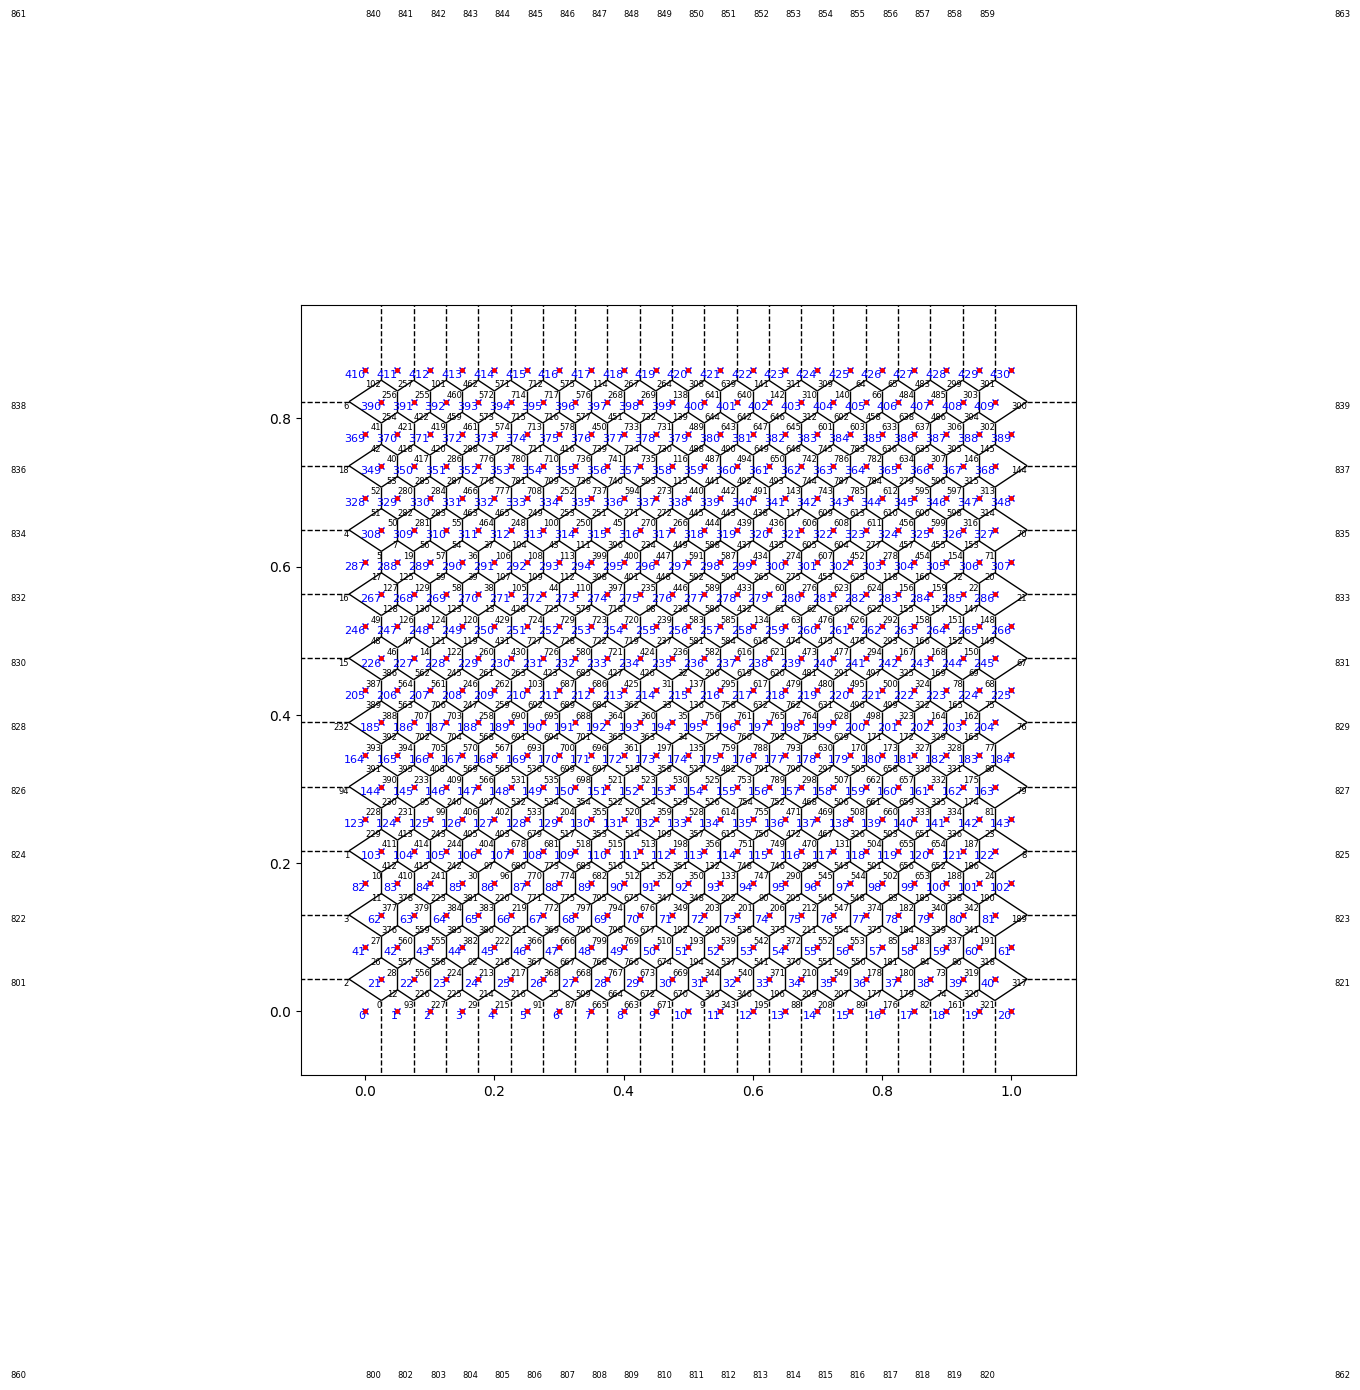

In [48]:
#plot 2d voronoi diagram
fig, ax = plt.subplots(figsize=(10, 10))
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False,)
# plot cell centers
ax.plot(cell_centers[:, 0], cell_centers[:, 1], 'bx', label='Recovered cell centers', markersize=5, zorder=4)
#plot original points
ax.plot(points[:, 0], points[:, 1], 'r.', label='Original seeds', markersize=5, zorder=4)
# ax.plot(cell_centers_perturbed[:, 0], cell_centers_perturbed[:, 1], 'go', label='Recovered cell centers perturbed', markersize=5, zorder=4)
for i , (x,y) in enumerate(points):
    ax.text(x, y, str(i), color='blue', fontsize=8, ha='right', va='top')
for i, (x,y) in enumerate(vertices):
    ax.text(x, y, str(i), color='black', fontsize=6, ha='right', va='top')

In [49]:
def nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi,vertices_perturbed):
    from mirror import mirror_point
    # This function calculates non-voronoiness for each seed based on the perturbed cell centers and explicit voronoi structure.
    # for each central seed n and for each neighboring seed m of n
    # reflect m's final position across the common edge with n
    # numerator = ||reflected_m - n_final||
    # denominator = || reflected_m - m_final||
    # return the mean ratio of neighbors
    nonvoronoiness = []
    for key in explicit_voronoi.keys():
        n_index = explicit_voronoi[key]['seed number']
        n_final = cell_centers_perturbed[n_index]
        neighbors = explicit_voronoi[key]['neighbors']
        ratios = []
        for m_index in neighbors:
            m_final = cell_centers_perturbed[m_index]
            print('n_index:',n_index,'m_index:',m_index)
            # find common edge
            edges_of_n = explicit_voronoi[key]['edges']
            edges_of_m = explicit_voronoi[f'sub_dict_{m_index}']['edges']
            common_edges = [edge for edge in edges_of_n if edge in edges_of_m]
            print('common edge:', common_edges)
            # mirror m_final across the common edge
            common_vertex1_coord = vertices_perturbed[common_edges[0][0]]
            common_vertex2_coord = vertices_perturbed[common_edges[0][1]]
            
            reflected_m = mirror_point(m_final, common_vertex1_coord, common_vertex2_coord)
            # calculate distances
            distance_to_n_final = np.linalg.norm(reflected_m - n_final)
            distance_to_m_final = np.linalg.norm(reflected_m - m_final)
            ratio = distance_to_n_final / distance_to_m_final
            ratios.append(ratio)
        nonvoronoiness.append(float(np.mean(ratios)))
    return nonvoronoiness

nonvoronoiness = nonvoronoiness_per_seed(cell_centers_perturbed, explicit_voronoi_perturbed,vertices_perturbed)

print('nonvoronoiness per seed :', nonvoronoiness)


n_index: 0 m_index: 1
common edge: [[800, 0]]
n_index: 0 m_index: 21
common edge: [[0, 2]]
n_index: 0 m_index: 41
common edge: [[801, 2]]
n_index: 1 m_index: 0
common edge: [[800, 0]]
n_index: 1 m_index: 2
common edge: [[802, 93]]
n_index: 1 m_index: 21
common edge: [[0, 12]]
n_index: 1 m_index: 22
common edge: [[12, 93]]
n_index: 2 m_index: 1
common edge: [[802, 93]]
n_index: 2 m_index: 3
common edge: [[803, 227]]
n_index: 2 m_index: 22
common edge: [[226, 93]]
n_index: 2 m_index: 23
common edge: [[226, 227]]
n_index: 3 m_index: 2
common edge: [[803, 227]]
n_index: 3 m_index: 4
common edge: [[804, 29]]
n_index: 3 m_index: 23
common edge: [[225, 227]]
n_index: 3 m_index: 24
common edge: [[225, 29]]
n_index: 4 m_index: 3
common edge: [[804, 29]]
n_index: 4 m_index: 5
common edge: [[805, 215]]
n_index: 4 m_index: 24
common edge: [[29, 214]]
n_index: 4 m_index: 25
common edge: [[214, 215]]
n_index: 5 m_index: 4
common edge: [[805, 215]]
n_index: 5 m_index: 6
common edge: [[806, 91]]
n_ind

C:\Users\user\AppData\Local\Temp\ipykernel_22660\631454542.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=8)


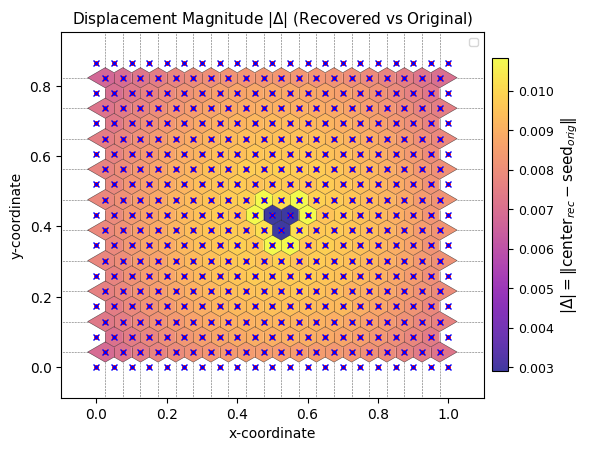

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial import Voronoi, voronoi_plot_2d

# ------------------------------------------------------------
# 1️⃣  Compute per-cell displacement magnitude
# ------------------------------------------------------------
N_real = len(points)
disp = np.linalg.norm(cell_centers_perturbed - all_points, axis=1)

# ------------------------------------------------------------
# 2️⃣  Rebuild Voronoi using the same ghost padding as inside your function
# ------------------------------------------------------------
# buffer = 0.1
# xmin, ymin = np.min(points, axis=0) - buffer
# xmax, ymax = np.max(points, axis=0) + buffer

# ghost_x = np.linspace(xmin, xmax, 10)
# ghost_y = np.linspace(ymin, ymax, 10)
# ghosts = np.array([[x, y] for x in ghost_x for y in ghost_y
#                    if (x < np.min(points[:, 0]) or x > np.max(points[:, 0]) or
#                        y < np.min(points[:, 1]) or y > np.max(points[:, 1]))])

# all_points = np.vstack([points, ghosts])
# vor = Voronoi(all_points)

# ------------------------------------------------------------
# 3️⃣  Build colored finite polygons (central cells only)
# ------------------------------------------------------------
patches, colors = [], []
for i in range(N_real):
    region_index = vor.point_region[i]
    region = vor.regions[region_index]
    if -1 in region or len(region) == 0:
        continue  # skip infinite regions
    polygon = np.array([vor.vertices[j] for j in region])
    patches.append(Polygon(polygon, closed=True))
    colors.append(disp[i])

# ------------------------------------------------------------
# 4️⃣  Plot setup (a_periodic style)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))

pc = PatchCollection(
    patches,
    cmap='plasma',
    edgecolor='none',
    alpha=0.8
)
pc.set_array(np.array(colors))
ax.add_collection(pc)

# Overlay Voronoi edges
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False,
                line_colors='black', line_width=0.4, line_alpha=0.6)

# Add seed points
# ax.scatter(points[:, 0], points[:, 1], c='red', s=8, label='Original seeds', zorder=3)

# ------------------------------------------------------------
# 5️⃣  Axes & colorbar styling
# ------------------------------------------------------------
ax.set_aspect('equal')
ax.set_facecolor('white')
ax.set_xlabel('x-coordinate', fontsize=10)
ax.set_ylabel('y-coordinate', fontsize=10)
ax.set_title('Displacement Magnitude $|Δ|$ (Recovered vs Original)', fontsize=11)
ax.legend(loc='upper right', fontsize=8)
#plot cell centers
# ax.plot(cell_centers_perturbed[:, 0], cell_centers_perturbed[:, 1], 'r.', label='Recovered cell centers', markersize=5, zorder=4)
ax.plot(points[:, 0], points[:, 1], 'r.', label='Original seeds', markersize=5, zorder=4)
ax.plot(cell_centers[:, 0], cell_centers[:, 1], 'bx', label='Recovered cell centers (no perturb)', markersize=5, zorder=4)

cbar = plt.colorbar(pc, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label(r'$|\Delta| = \|\mathrm{center}_{rec} - \mathrm{seed}_{orig}\|$', fontsize=11)
cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_22660\902142296.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=8)


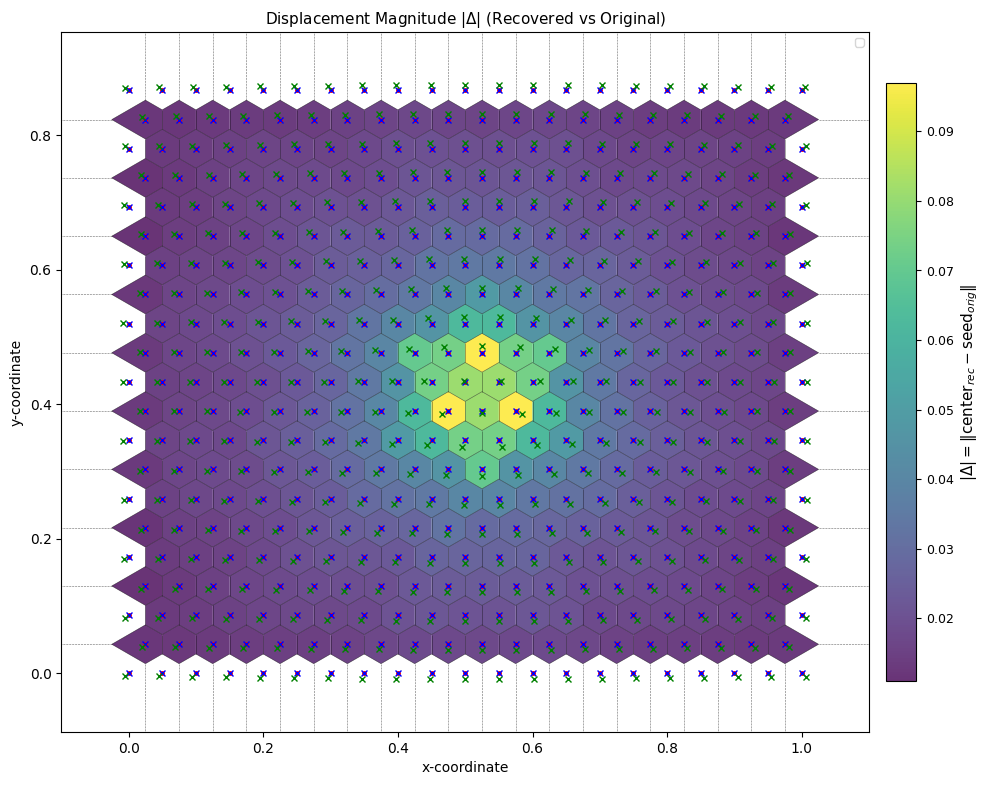

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial import Voronoi, voronoi_plot_2d




# ------------------------------------------------------------
# 3️⃣  Build colored finite polygons (central cells only)
# ------------------------------------------------------------
patches, colors = [], []
for i in range(len(all_points)):
    r_idx = vor.point_region[i]
    region = vor.regions[r_idx]
    if not region or -1 in region:   # skip infinite/invalid regions
        continue
    poly = vor.vertices[region]
    patches.append(Polygon(poly, closed=True))
    # colors should be log the nonvoronoiness value
    colors.append((nonvoronoiness[i]))            # color by displacement of seed i

# ------------------------------------------------------------
# 4️⃣  Plot setup (a_periodic style)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 10))

pc = PatchCollection(
    patches,
    cmap='viridis', 
    edgecolor='none',
    alpha=0.8
)
pc.set_array(np.array(colors))
ax.add_collection(pc)

# Overlay Voronoi edges
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False,
                line_colors='black', line_width=0.4, line_alpha=0.6)

# Add seed points
# ax.scatter(points[:, 0], points[:, 1], c='red', s=8, label='Original seeds', zorder=3)

# ------------------------------------------------------------
# 5️⃣  Axes & colorbar styling
# ------------------------------------------------------------
ax.set_aspect('equal')
ax.set_facecolor('white')
ax.set_xlabel('x-coordinate', fontsize=10)
ax.set_ylabel('y-coordinate', fontsize=10)
ax.set_title('Displacement Magnitude $|Δ|$ (Recovered vs Original)', fontsize=11)
ax.legend(loc='upper right', fontsize=8)
#plot cell centers
# ax.plot(cell_centers_perturbed[:, 0], cell_centers_perturbed[:, 1], 'r.', label='Recovered cell centers', markersize=5, zorder=4)
ax.plot(points[:, 0], points[:, 1], 'r.', label='Original seeds', markersize=5, zorder=4)
ax.plot(cell_centers[:, 0], cell_centers[:, 1], 'bx', label='Recovered cell centers (no perturb)', markersize=5, zorder=4)
ax.plot(cell_centers_perturbed[:, 0], cell_centers_perturbed[:, 1], 'gx', label='Recovered cell centers perturbed', markersize=5, zorder=4)

cbar = plt.colorbar(pc, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label(r'$|\Delta| = \|\mathrm{center}_{rec} - \mathrm{seed}_{orig}\|$', fontsize=11)
cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()


[[-1.19844322e-15  2.07433650e-15]
 [ 5.00000000e-02  1.42913897e-16]
 [ 1.00000000e-01 -6.95436547e-16]
 [ 1.50000000e-01 -1.08569974e-15]
 [ 2.00000000e-01 -6.47521560e-16]
 [ 2.50000000e-01 -1.12226099e-15]
 [ 3.00000000e-01 -1.40073024e-15]
 [ 3.50000000e-01 -1.04308380e-15]
 [ 4.00000000e-01 -1.04951393e-15]
 [ 4.50000000e-01 -1.67092601e-15]
 [ 5.00000000e-01 -1.59330393e-15]
 [ 5.50000000e-01 -1.16295360e-15]
 [ 6.00000000e-01 -1.30550827e-15]
 [ 6.50000000e-01 -1.23505066e-15]
 [ 7.00000000e-01 -1.14427218e-15]
 [ 7.50000000e-01 -1.04671270e-15]
 [ 8.00000000e-01 -6.63329477e-16]
 [ 8.50000000e-01 -1.12389831e-15]
 [ 9.00000000e-01 -8.74791350e-16]
 [ 9.50000000e-01 -8.57350988e-16]
 [ 1.00000000e+00 -2.85591942e-15]
 [ 2.50000000e-02  4.33012702e-02]
 [ 7.50000000e-02  4.33012702e-02]
 [ 1.25000000e-01  4.33012702e-02]
 [ 1.75000000e-01  4.33012702e-02]
 [ 2.25000000e-01  4.33012702e-02]
 [ 2.75000000e-01  4.33012702e-02]
 [ 3.25000000e-01  4.33012702e-02]
 [ 3.75000000e-01  4

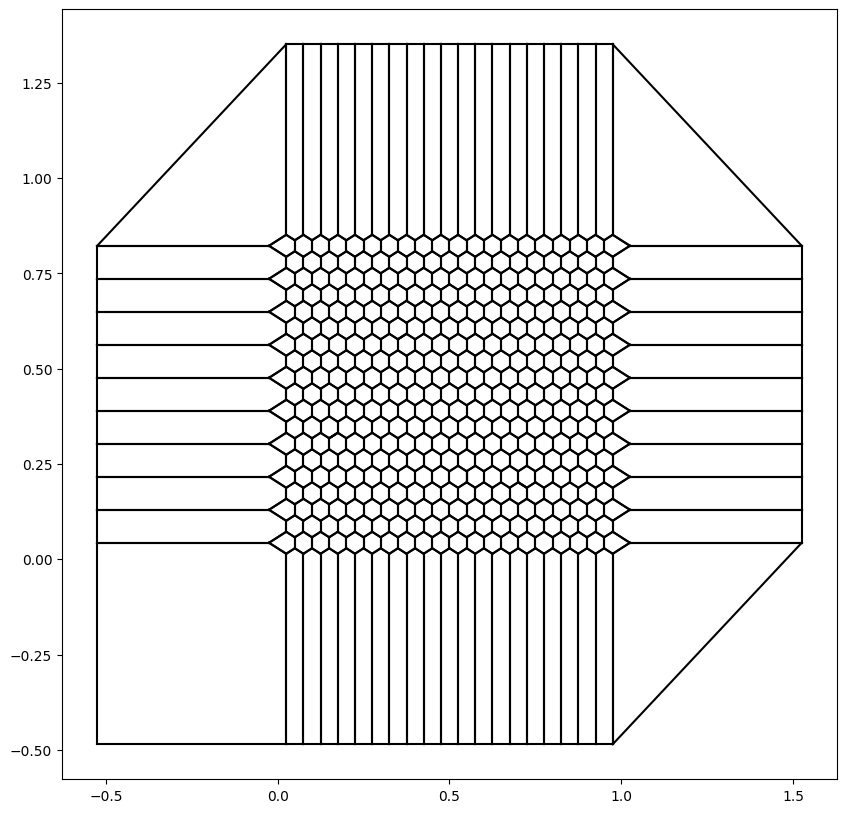

In [11]:
from Plot_Voronoi import PlotVoronoi
fig,ax = plt.subplots(figsize=(10,10))
PlotVoronoi(cell_centers,explicit_voronoi,vertices,ax)